In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

## Overview
1. load the data from df_train.csv
2. Extract the numerical features from the data (df_numeric)
3. Apply DBSCAN and compare the shilouette score
   - df_numeric
   - standardized df_numeric
   - scaled df_numeric
4. Analyze the best model

 ## Limitation
 I use all numerical features, and standardize or/and scale them.
 
 If I select the features to train or select the feature to standardize or scale, the result might be different.

 This is the next step after methodology submission assignment.

## 1. load the data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_sample_5000.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(5000, 23)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
2,fo_order_id,object,0,df_orders,FK
3,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
4,fo_order_status,object,0,df_orders,
5,fo_order_purchase_timestamp,object,0,df_orders,
6,fo_order_approved_at,object,0,df_orders,
7,fo_order_delivered_carrier_date,object,0,df_orders,
8,fo_order_delivered_customer_date,object,0,df_orders,
9,fo_order_estimated_delivery_date,object,0,df_orders,


## 2. Prepare df_numeric

In [3]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(4843, 10)


,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
0,0,376,2,403.81,1,1,-10.0,4.0,0.0,0
1,0,351,1,95.11,1,1,0.0,4.0,0.0,0
2,0,336,1,75.42,1,1,-12.0,4.0,0.0,0
3,0,477,1,148.06,1,1,-12.0,3.0,0.0,0
4,0,252,0,58.62,1,1,-9.0,3.0,0.0,1


## 3. Apply DBSCAN and compare the shilouette score
 - df_numeric
 - standardized df_numeric
 - scaled df_numeric

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering_for_eps_range(data, eps_values, min_samples=5):
    results = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)
        label_nums = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)  # Adjust for noise label

        if label_nums > 1:  # Ensure more than one cluster (excluding noise)
            silhouette = silhouette_score(data, dbscan.labels_)
            dbi = davies_bouldin_score(data, dbscan.labels_)
        else:
            silhouette = np.nan  # Use NaN to indicate N/A
            dbi = np.nan
        results.append((eps, label_nums, silhouette, dbi))
    return results

def plot_results(results):
    eps_values = [result[0] for result in results]
    silhouette_scores = [result[2] for result in results]
    dbi_scores = [result[3] for result in results]

    # plot Silhouette Score
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eps_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. eps')
    plt.xlabel('eps value')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # plot DBI
    plt.subplot(1, 2, 2)
    plt.plot(eps_values, dbi_scores, marker='o', color='red')
    plt.title('Davies-Bouldin Index vs. eps')
    plt.xlabel('eps value')
    plt.ylabel('Davies-Bouldin Index')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

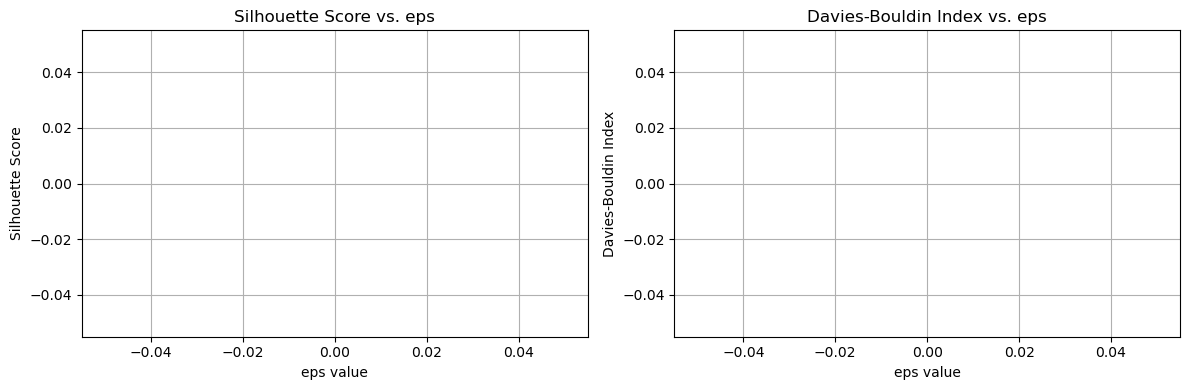

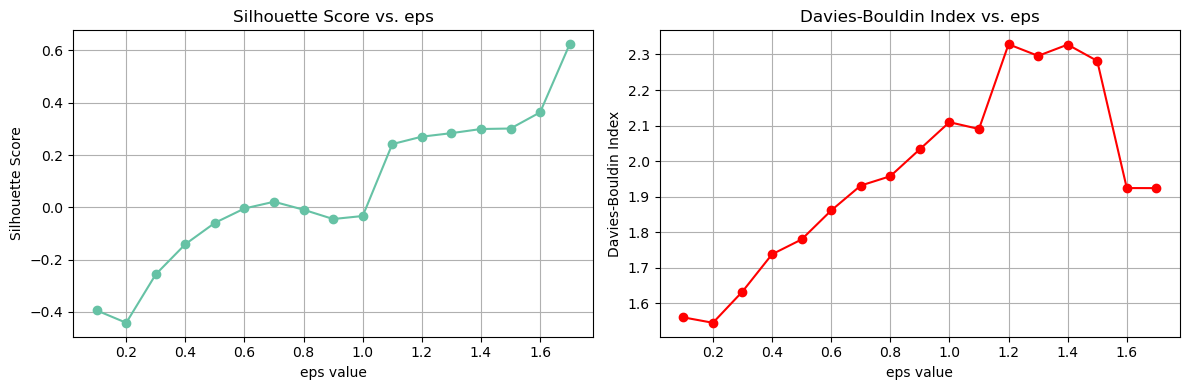

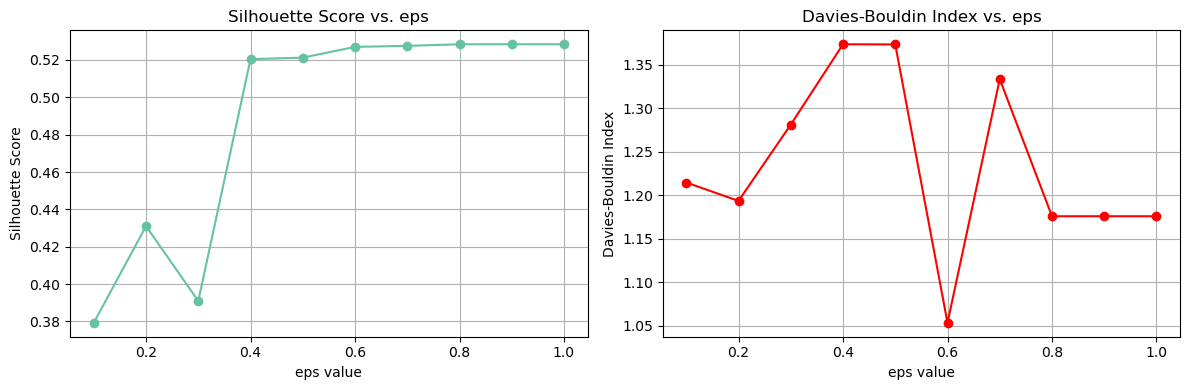

In [5]:
from utils import standardize, normalize

# results = []
eps_values = np.linspace(0.1, 2.0, 20)

# Original data
results_orig = evaluate_clustering_for_eps_range(df_numeric, eps_values)
plot_results(results_orig)

# Standardized data
df_std = standardize(df_numeric)
results_std = evaluate_clustering_for_eps_range(df_std, eps_values)
plot_results(results_std)

# Normalized data
df_normalized = normalize(df_numeric)
results_norm = evaluate_clustering_for_eps_range(df_normalized, eps_values)
plot_results(results_norm)


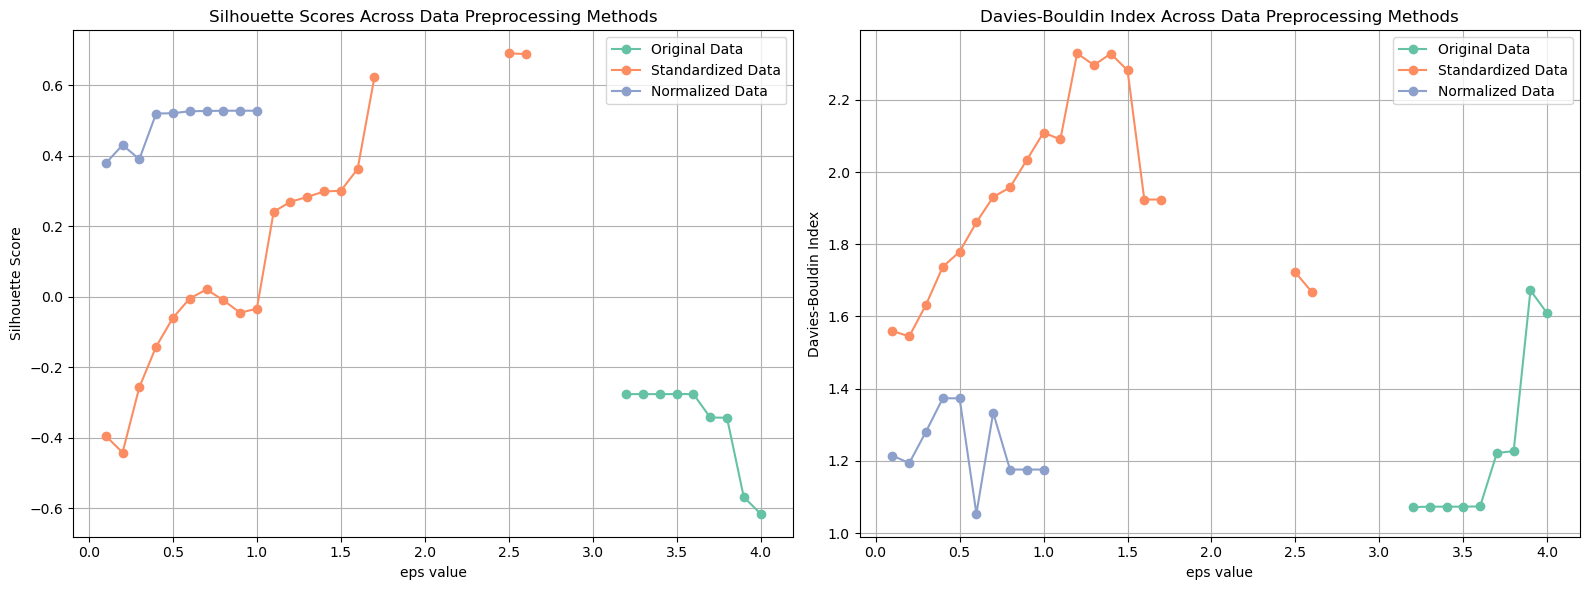

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from utils import standardize, normalize

def evaluate_clustering_for_eps_range(data, eps_values, min_samples=5):
    results = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)
        label_nums = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)  # Adjust for noise label

        if label_nums > 1:  # Ensure more than one cluster (excluding noise)
            silhouette = silhouette_score(data, dbscan.labels_)
            dbi = davies_bouldin_score(data, dbscan.labels_)
        else:
            silhouette = np.nan  # Use NaN to indicate N/A
            dbi = np.nan
        results.append({'eps': eps, 'Silhouette': silhouette, 'DBI': dbi})
    return results

def plot_results(all_results, eps_values):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for key, results in all_results.items():
        plt.plot(eps_values, [result['Silhouette'] for result in results], marker='o', label=f'{key}')
    plt.title('Silhouette Scores Across Data Preprocessing Methods')
    plt.xlabel('eps value')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for key, results in all_results.items():
        plt.plot(eps_values, [result['DBI'] for result in results], marker='o', label=f'{key}')
    plt.title('Davies-Bouldin Index Across Data Preprocessing Methods')
    plt.xlabel('eps value')
    plt.ylabel('Davies-Bouldin Index')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

eps_values = np.linspace(0.1, 4.0, 40)
all_results = {}

# Process each type of data
for data_type, func in [('Original Data', lambda x: x),
                        ('Standardized Data', standardize),
                        ('Normalized Data', normalize)]:
    processed_data = func(df_numeric)
    results = evaluate_clustering_for_eps_range(processed_data, eps_values)
    all_results[data_type] = results

plot_results(all_results, eps_values)

**Interpretation**

When data is normalized rather than standardized, performance in clustering tasks can often improve due to the distinct way normalization treats the features. Normalization rescales the data to fit within a specific range, typically [0, 1], ensuring that each feature contributes equally to the distance calculations, which are critical in clustering algorithms. This uniform treatment is particularly beneficial when the original data spans various scales or units across features, as it prevents any single feature from disproportionately influencing the cluster formation. Moreover, normalization maintains the relative distances and structures within the data, which can be crucial for capturing the natural groupings, especially in datasets where the inherent distribution of data points isn't spherical. This approach can lead to a more meaningful and accurate clustering outcome, as it better aligns with the underlying densities and distributions present in the data. Consequently, in scenarios where data features vary widely in scale or where the distribution of data points forms complex shapes, normalization can significantly enhance the performance of clustering algorithms like DBSCAN by preserving the intrinsic geometrical properties of the dataset.

## 4. Analyze the best model

In [6]:
from utils import get_comparison_df
## I chose df_normalized as the best model

## train the model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_normalized)
labels = dbscan.labels_
## estimate the centroids
clusters = pd.DataFrame(df_normalized).assign(Cluster=labels)
centroids = clusters.groupby('Cluster').mean().reset_index()
## Remove noise
centroids = centroids[centroids.Cluster != -1]
centroids_df = pd.DataFrame(centroids, columns=df_normalized.columns)
print(f"centroids_df shape: {centroids_df.shape}")

centroids_comparison_df = get_comparison_df(df_normalized, centroids_df)
centroids_comparison_df

## get the count of each cluster
clusters = pd.DataFrame(labels, columns=['Cluster'])
clusters_count = clusters['Cluster'].value_counts().reset_index()
clusters_count.columns = ['Cluster', 'Count']
clusters_count


centroids_df shape: (13, 10)


,Cluster,Count
0,0,1925
1,1,1319
2,2,569
3,4,421
4,6,202
5,7,167
6,5,58
7,3,46
8,8,41
9,9,36


In [7]:
## Analyze the noise
noise_points = clusters[clusters.Cluster == -1]
noise_points.describe()

,Cluster
count,30.0
mean,-1.0
std,0.0
min,-1.0
25%,-1.0
50%,-1.0
75%,-1.0
max,-1.0


### Visualization

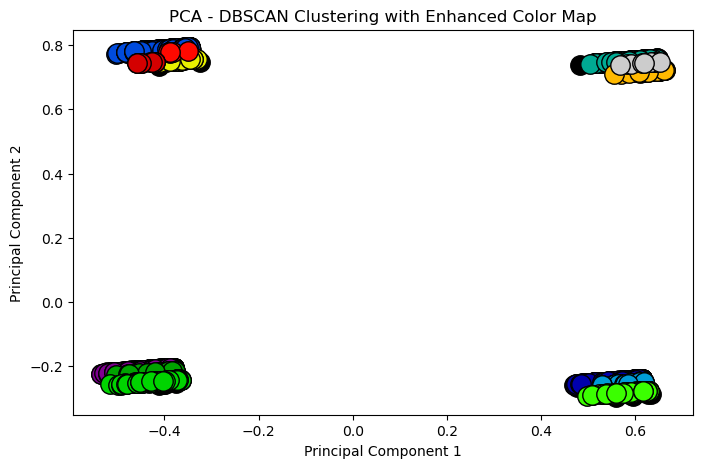

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized)

plt.figure(figsize=(8, 5))
unique_labels = np.unique(dbscan.labels_)
colors = [plt.cm.nipy_spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k' # Black used for noise.

    class_member_mask = (dbscan.labels_ == k)

    xy = pca_result[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

plt.title('PCA - DBSCAN Clustering with Enhanced Color Map')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Interpretation**
- Cluster Separation: The clusters appear to be well-separated in the PCA-reduced space, which suggests that DBSCAN was successful in identifying distinct high-density areas in the original high-dimensional space.

- Density Variations: The varying sizes and densities of the clusters may indicate differences in the concentration of data points within each group, which reflects the underlying data structure DBSCAN is leveraging for clustering.

- PCA Interpretation: Since PCA reduces dimensionality by maximizing variance along its principal components, the visualization provides a view that best represents the differences between clusters, as understood by the DBSCAN algorithm.

- When the data points in Principal Component 1 (PC1) are primarily distributed around -0.2 and 0.8, it indicates a potential bi-modal distribution within the dataset, suggesting two dominant groups of variance. This distribution could imply that certain features or combinations thereof exhibit significant variation at these specific values, with limited variability in other ranges. The concentration of points might reflect specific characteristics or states within the dataset, indicating the existence of underlying subgroups or categories. If this clustering of values occurs after normalization, it may also point to the influence of outliers or specific data scaling methods applied during preprocessing.